<a href="https://colab.research.google.com/github/canast07/EPL448-Ticket-price/blob/canast07/EPL448_2nd_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [33]:
trainData = pd.read_excel("Data_Train.xlsx")
testData = pd.read_excel("Test_set.xlsx")
sampData = pd.read_excel("Sample_submission.xlsx")

trainData.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [34]:
trainData.isnull().sum() # check for nulls

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [35]:
trainData.dropna(inplace=True) # Drop the rows that have null fields
print(trainData.isnull().sum())
trainData.dtypes # check the types

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64


Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

In [36]:
testData.isnull().sum() # check for nulls

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

**This is our 2nd Approach where we will check more data**

In [37]:
train = trainData.copy()
test = testData.copy()
concatData = pd.concat(objs=[train,test],axis=0)


In [38]:
concatData['Day'] = concatData['Date_of_Journey'].str.split('/').str[0]
concatData['Month'] = concatData['Date_of_Journey'].str.split('/').str[1]
concatData['Year'] = concatData['Date_of_Journey'].str.split('/').str[2]
concatData["Day"]= concatData["Day"].astype('int64')
concatData["Month"]= concatData["Month"].astype('int64')
concatData["Month"]= concatData["Month"].astype('int64')
concatData.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Day,Month,Year
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897.0,24,3,2019
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662.0,1,5,2019
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882.0,9,6,2019
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218.0,12,5,2019
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302.0,1,3,2019


In [39]:
concatData.Airline.value_counts()

Jet Airways                          4746
IndiGo                               2564
Air India                            2191
Multiple carriers                    1543
SpiceJet                             1026
Vistara                               608
Air Asia                              405
GoAir                                 240
Multiple carriers Premium economy      16
Jet Airways Business                    8
Vistara Premium economy                 5
Trujet                                  1
Name: Airline, dtype: int64

In [40]:
concatData = concatData.drop(['Route'], axis = 1)
concatData.head()

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Day,Month,Year
0,IndiGo,24/03/2019,Banglore,New Delhi,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897.0,24,3,2019
1,Air India,1/05/2019,Kolkata,Banglore,05:50,13:15,7h 25m,2 stops,No info,7662.0,1,5,2019
2,Jet Airways,9/06/2019,Delhi,Cochin,09:25,04:25 10 Jun,19h,2 stops,No info,13882.0,9,6,2019
3,IndiGo,12/05/2019,Kolkata,Banglore,18:05,23:30,5h 25m,1 stop,No info,6218.0,12,5,2019
4,IndiGo,01/03/2019,Banglore,New Delhi,16:50,21:35,4h 45m,1 stop,No info,13302.0,1,3,2019


In [41]:
concatData['Airline'] = concatData['Airline'].astype('category')
concatData['Airline'] = concatData['Airline'].cat.codes
concatData.head()

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Day,Month,Year
0,3,24/03/2019,Banglore,New Delhi,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897.0,24,3,2019
1,1,1/05/2019,Kolkata,Banglore,05:50,13:15,7h 25m,2 stops,No info,7662.0,1,5,2019
2,4,9/06/2019,Delhi,Cochin,09:25,04:25 10 Jun,19h,2 stops,No info,13882.0,9,6,2019
3,3,12/05/2019,Kolkata,Banglore,18:05,23:30,5h 25m,1 stop,No info,6218.0,12,5,2019
4,3,01/03/2019,Banglore,New Delhi,16:50,21:35,4h 45m,1 stop,No info,13302.0,1,3,2019


In [42]:
concatData['Source'] = concatData['Source'].astype('category')
concatData['Source'] = concatData['Source'].cat.codes

In [43]:
concatData['Destination'] = concatData['Destination'].astype('category')
concatData['Destination'] = concatData['Destination'].cat.codes

In [44]:
arr = np.empty((concatData['Duration'].count()))
concatData = concatData.reset_index(drop = True)
print(len(arr))
i = 0
for x in concatData['Duration']:
  # print("x", x)
  hours = 0
  minutes = 0
  if 'h' in str(x):
    tokens = str(x).split("h")
    hours = int(tokens[0]) * 60
    # print("hours = ", hours)
    if 'm' in str(x):
      temp = tokens[1].replace(' ', '').replace('m','')
      minutes = int(temp)
  else:
    temp = tokens[1].replace(' ', '').replace('m','')
    minutes = int(temp)
  time = hours + minutes
  arr[i] = time
  i += 1
  concatData['Duration'] = pd.Series(arr.astype(int))

13353


In [45]:
concatData.Dep_Time.value_counts()

18:55    288
17:00    275
10:00    265
07:05    240
07:10    239
        ... 
21:40      1
03:00      1
21:35      1
12:45      1
12:05      1
Name: Dep_Time, Length: 223, dtype: int64

In [46]:
concatData['Dep_Time'] = concatData['Dep_Time'].astype('category')
concatData['Dep_Time'] = concatData['Dep_Time'].cat.codes

In [47]:
concatData['Dep_Time'] = concatData['Dep_Time'].astype('category')
concatData['Dep_Time'] = concatData['Dep_Time'].cat.codes

In [48]:
concatData['Total_Stops'] = concatData['Total_Stops'].astype('category')
concatData['Total_Stops'] = concatData['Total_Stops'].cat.codes

In [49]:
concatData['Additional_Info'] = concatData['Additional_Info'].astype('category')
concatData['Additional_Info'] = concatData['Additional_Info'].cat.codes

In [50]:
concatData = concatData.drop(['Date_of_Journey', 'Arrival_Time', 'Year'], axis=1)

In [51]:
concatData.head()

,Airline,Source,Destination,Dep_Time,Duration,Total_Stops,Additional_Info,Price,Day,Month
0,3,0,5,211,170,4,8,3897.0,24,3
1,1,3,0,31,445,1,8,7662.0,1,5
2,4,2,1,70,1140,1,8,13882.0,9,6
3,3,3,0,164,325,0,8,6218.0,12,5
4,3,0,5,149,285,0,8,13302.0,1,3


**Now Split the data**

In [52]:
train_size = len(train)
train = concatData[:train_size]
test = concatData[train_size:]
test = test.drop(['Price'], axis = 1)

In [53]:
train

,Airline,Source,Destination,Dep_Time,Duration,Total_Stops,Additional_Info,Price,Day,Month
0,3,0,5,211,170,4,8,3897.0,24,3
1,1,3,0,31,445,1,8,7662.0,1,5
2,4,2,1,70,1140,1,8,13882.0,9,6
3,3,3,0,164,325,0,8,6218.0,12,5
4,3,0,5,149,285,0,8,13302.0,1,3
...,...,...,...,...,...,...,...,...,...,...
10677,0,3,0,183,150,4,8,4107.0,9,4
10678,1,3,0,193,155,4,8,4145.0,27,4
10679,4,0,2,58,180,4,8,7229.0,27,4
10680,10,0,5,92,160,4,8,12648.0,1,3


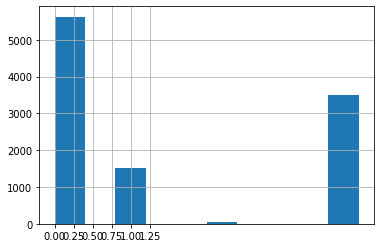

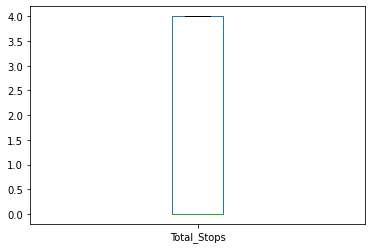

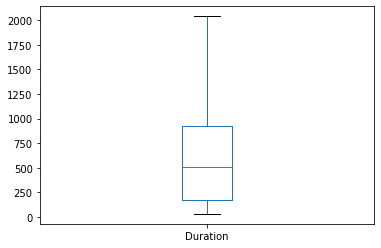

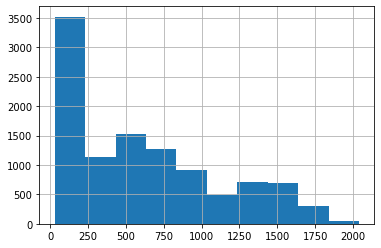

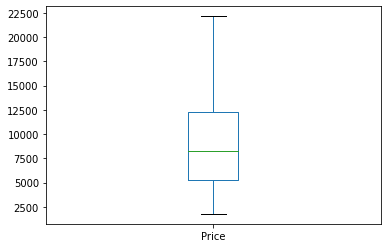

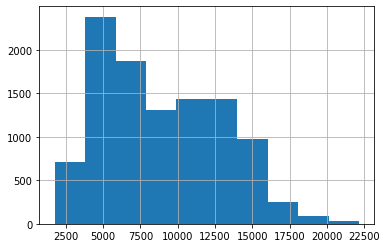

In [54]:
median = np.percentile(train.Total_Stops,50)  # median
std = train.Total_Stops.std() # standard deviation 
train = train.drop(train[ train.Total_Stops > (median+3*std)].index) # drop "outliers " that are > median + 3*std
train['Total_Stops'].hist()
plt.xticks([0.0,0.25,0.5,0.75,1.0, 1.25])
plt.show()
train['Total_Stops'].plot(kind='box', subplots=True)
plt.show()

# Remove outliers of Duration
median = np.percentile(train.Duration,50)  # median
std = train.Duration.std() # standard deviation 
train = train.drop(train[ train.Duration > (median+3*std)].index) # drop "outliers " that are > median + 3*std
train['Duration'].plot(kind='box', subplots=True)
plt.show()
train['Duration'].hist()
plt.show()

# Remove price outliers
median = np.percentile(train.Price,50)  # median
std = train.Price.std() # standard deviation 
train = train.drop(train[ train.Price > (median+3*std)].index) # drop "outliers " that are > median + 3*std
train['Price'].plot(kind='box', subplots=True)
plt.show()
train['Price'].hist()
plt.show()

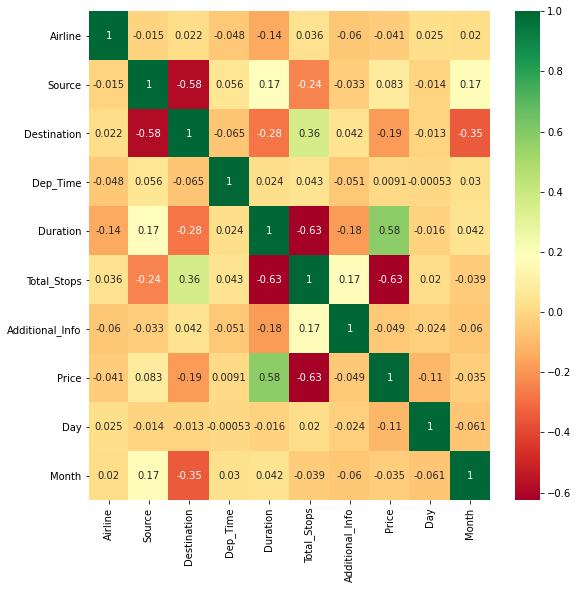

In [55]:
plt.figure(figsize=(9,9))
sns.heatmap(train.corr(), annot=True, cmap='RdYlGn')

In [56]:
x = train.drop(['Price'], axis = 1)
y = train.Price.values

In [57]:
from sklearn.pipeline import Pipeline
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledDT', Pipeline([('Scaler', StandardScaler()),('DT', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF',RandomForestRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR',SVR())])))
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=21)
    cv_results = cross_val_score(model, x, y, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name,-cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 8489037.412852 (311569.122709)
ScaledLASSO: 8489047.536128 (311734.957044)
ScaledEN: 9036043.004970 (412394.588083)
ScaledKNN: 3230149.440566 (193645.912911)
ScaledDT: 2323614.948977 (185166.772523)
ScaledGBM: 2781844.563860 (171361.713783)
ScaledRF: 1435340.808346 (101036.875345)
ScaledSVR: 14697379.396282 (827976.335626)


### **Random Forest Regression**

In [58]:
scaler = StandardScaler().fit(x)
rescaled_X_train = scaler.transform(x)
model = RandomForestRegressor()
model.fit(rescaled_X_train, y)

scaler = StandardScaler().fit(test)
rescaled_X_test = scaler.transform(test)
predictions = model.predict(rescaled_X_test)

df_dt = pd.DataFrame(predictions.astype(int))
df_dt.columns=['Price']
filepath_dt = 'Predictions_RandomForest_2nd.xlsx'
df_dt.to_excel(filepath_dt, index=False)
df_dt.head()

,Price
0,14714
1,4292
2,12898
3,11388
4,3747


### **SVR**

In [59]:
scaler = StandardScaler().fit(x)
rescaled_X_train = scaler.transform(x)
model = SVR()
model.fit(rescaled_X_train, y)

scaler = StandardScaler().fit(test)
rescaled_X_test = scaler.transform(test)
predictions = model.predict(rescaled_X_test)

df_dt = pd.DataFrame(predictions.astype(int))
df_dt.columns=['Price']
filepath_dt = 'Predictions_SVR_2nd.xlsx'
df_dt.to_excel(filepath_dt, index=False)
df_dt.head()

,Price
0,8535
1,8268
2,8700
3,8461
4,7584


### **Gradient Boosting Regression**

In [60]:
scaler = StandardScaler().fit(x)
rescaled_X_train = scaler.transform(x)
model = GradientBoostingRegressor()
model.fit(rescaled_X_train, y)

scaler = StandardScaler().fit(test)
rescaled_X_test = scaler.transform(test)
predictions = model.predict(rescaled_X_test)

df_dt = pd.DataFrame(predictions.astype(int))
df_dt.columns=['Price']
filepath_dt = 'Predictions_GradientBoosting_2nd.xlsx'
df_dt.to_excel(filepath_dt, index=False)
df_dt.head()

,Price
0,13629
1,5080
2,10848
3,9851
4,4102


### **Decision Tree Regression**

In [61]:
scaler = StandardScaler().fit(x)
rescaled_X_train = scaler.transform(x)
model = DecisionTreeRegressor()
model.fit(rescaled_X_train, y)

scaler = StandardScaler().fit(test)
rescaled_X_test = scaler.transform(test)
predictions = model.predict(rescaled_X_test)

df_dt = pd.DataFrame(predictions.astype(int))
df_dt.columns=['Price']
filepath_dt = 'Predictions_DecisionTree_2nd.xlsx'
df_dt.to_excel(filepath_dt, index=False)
df_dt.head()

,Price
0,14714
1,4226
2,12898
3,10348
4,3383
